In [1]:
# Initial imports
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pandas import get_dummies
import sqlite3

In [2]:
# Establish connection to sqlite database
conn = sqlite3.connect("depression.db")

In [3]:
# Load data into Pandas DataFrame
student_df = pd.read_csv("../Resources/student_depression_dataset.csv")

In [4]:
# Load DataFrame into sqlite database
student_df.to_sql("depression", conn, if_exists="replace", index=False)

27901

In [5]:
# Load SQL table into Pandas DataFrame
query = "SELECT * FROM depression"
student_df = pd.read_sql_query(query, conn)
student_df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [6]:
# Number of depressed students
student_df["Age"].min()

18.0

In [7]:
# Professions in dataset
student_df["Family History of Mental Illness"].value_counts()

Family History of Mental Illness
No     14398
Yes    13503
Name: count, dtype: int64

In [8]:
# Average academic pressure
ac_pres_avg = student_df.groupby(by=["Profession"])[["Academic Pressure"]].mean()
ac_pres_avg

,Academic Pressure
Profession,
'Civil Engineer',5.000000
'Content Writer',5.000000
'Digital Marketer',3.666667
'Educational Consultant',3.000000
'UX/UI Designer',3.000000
Architect,3.750000
Chef,2.500000
Doctor,4.000000
Entrepreneur,3.000000


In [9]:
# Unique cities in dataset
student_df.City.unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', 'Saanvi', 'M.Tech', 'Bhavna', "'Less Delhi'",
       'City', '3.0', "'Less than 5 Kalyan'", 'Mira', 'Harsha', 'Vaanya',
       'Gaurav', 'Harsh', 'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com',
       'Nalyan', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad'], dtype=object)

In [10]:
# Define features
X = student_df.copy().drop(["Depression", "id"], axis=1)
X.head(5)


,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No


In [11]:
# Define target
y = student_df["Depression"]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: Depression, dtype: int64

In [12]:
# Use get dummies to change categorical data to True/False.
columns_to_dummy = ["Profession", "City", "Gender", "Sleep Duration", "Dietary Habits", "Degree", "Have you ever had suicidal thoughts ?", "Family History of Mental Illness", "Financial Stress"]
X_dummies = pd.get_dummies(X[columns_to_dummy], columns=columns_to_dummy)
X = pd.concat([X, X_dummies], axis=1)
X = X.drop(columns=columns_to_dummy, axis=1)
X

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Profession_'Civil Engineer',Profession_'Content Writer',Profession_'Digital Marketer',...,Have you ever had suicidal thoughts ?_No,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_No,Family History of Mental Illness_Yes,Financial Stress_1.0,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0,Financial Stress_?
0,33.0,5.0,0.0,8.97,2.0,0.0,3.0,False,False,False,...,False,True,True,False,True,False,False,False,False,False
1,24.0,2.0,0.0,5.90,5.0,0.0,3.0,False,False,False,...,True,False,False,True,False,True,False,False,False,False
2,31.0,3.0,0.0,7.03,5.0,0.0,9.0,False,False,False,...,True,False,False,True,True,False,False,False,False,False
3,28.0,3.0,0.0,5.59,2.0,0.0,4.0,False,False,False,...,False,True,False,True,False,False,False,False,True,False
4,25.0,4.0,0.0,8.13,3.0,0.0,1.0,False,False,False,...,False,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,27.0,5.0,0.0,5.75,5.0,0.0,7.0,False,False,False,...,False,True,False,True,True,False,False,False,False,False
27897,27.0,2.0,0.0,9.40,3.0,0.0,0.0,False,False,False,...,True,False,False,True,False,False,True,False,False,False
27898,31.0,3.0,0.0,6.61,4.0,0.0,12.0,False,False,False,...,True,False,True,False,False,True,False,False,False,False
27899,18.0,5.0,0.0,6.88,2.0,0.0,10.0,False,False,False,...,False,True,True,False,False,False,False,False,True,False


In [13]:
# Display feature columns
X.columns.tolist()

['Age',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Work/Study Hours',
 "Profession_'Civil Engineer'",
 "Profession_'Content Writer'",
 "Profession_'Digital Marketer'",
 "Profession_'Educational Consultant'",
 "Profession_'UX/UI Designer'",
 'Profession_Architect',
 'Profession_Chef',
 'Profession_Doctor',
 'Profession_Entrepreneur',
 'Profession_Lawyer',
 'Profession_Manager',
 'Profession_Pharmacist',
 'Profession_Student',
 'Profession_Teacher',
 "City_'Less Delhi'",
 "City_'Less than 5 Kalyan'",
 'City_3.0',
 'City_Agra',
 'City_Ahmedabad',
 'City_Bangalore',
 'City_Bhavna',
 'City_Bhopal',
 'City_Chennai',
 'City_City',
 'City_Delhi',
 'City_Faridabad',
 'City_Gaurav',
 'City_Ghaziabad',
 'City_Harsh',
 'City_Harsha',
 'City_Hyderabad',
 'City_Indore',
 'City_Jaipur',
 'City_Kalyan',
 'City_Kanpur',
 'City_Khaziabad',
 'City_Kibara',
 'City_Kolkata',
 'City_Lucknow',
 'City_Ludhiana',
 'City_M.Com',
 'City_M.Tech',
 'City_ME',
 'C

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [15]:
# Create scaler instance and fit to train dataset
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [16]:
# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Create random forest binary classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)

In [18]:
# Fit model to scaled training data and y_train
rf_model = rf_model.fit(X_train_scaled, y_train)

In [19]:
# Make predictions for test data
predictions = rf_model.predict(X_test_scaled)

In [20]:
# Evaluate model using confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculate accuracy score
acc_score = accuracy_score(y_test, predictions)

In [21]:
# Display results of evaluation
print("Confusion Matrix")
display(conf_matrix_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2247,615
Actual 1,453,3661


Accuracy Score : 0.8469036697247706
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2862
           1       0.86      0.89      0.87      4114

    accuracy                           0.85      6976
   macro avg       0.84      0.84      0.84      6976
weighted avg       0.85      0.85      0.85      6976



In [22]:
# Calculate feature importance of the model
importances = rf_model.feature_importances_

# Sort importances by value
sorted(zip(importances, X.columns), reverse=True)

[(0.13166102585448206, 'Academic Pressure'),
 (0.11968977369673613, 'Have you ever had suicidal thoughts ?_No'),
 (0.10891603451737061, 'Have you ever had suicidal thoughts ?_Yes'),
 (0.06429242118558383, 'Age'),
 (0.060375577363877005, 'CGPA'),
 (0.05701155378463896, 'Work/Study Hours'),
 (0.03668449226817565, 'Study Satisfaction'),
 (0.030220633612777534, 'Financial Stress_5.0'),
 (0.029148391675321222, 'Financial Stress_1.0'),
 (0.016775021233697906, 'Dietary Habits_Unhealthy'),
 (0.013186246564655446, 'Financial Stress_2.0'),
 (0.013141378814288656, 'Dietary Habits_Healthy'),
 (0.01087553293966067, 'Financial Stress_4.0'),
 (0.010563301569310332, 'Gender_Female'),
 (0.010540650401401192, 'Gender_Male'),
 (0.010306433239859355, "Degree_'Class 12'"),
 (0.01024994156168505, "Sleep Duration_'Less than 5 hours'"),
 (0.00967965479372522, "Sleep Duration_'7-8 hours'"),
 (0.009400272197941472, "Sleep Duration_'More than 8 hours'"),
 (0.009127039559951216, "Sleep Duration_'5-6 hours'"),
 (0

<Axes: title={'center': 'Features Importances'}>

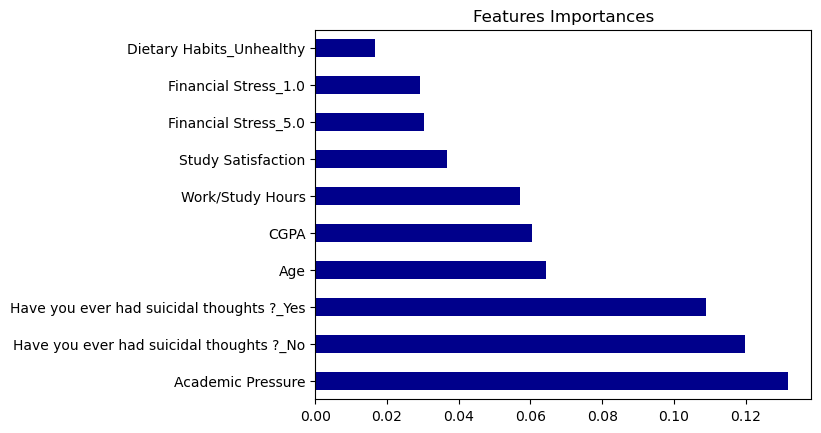

In [23]:
# Plot importances to bar graph
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted[0:10].plot(kind='barh', color='darkblue', title= 'Features Importances', legend=False, ylabel="")

<function matplotlib.pyplot.show(close=None, block=None)>

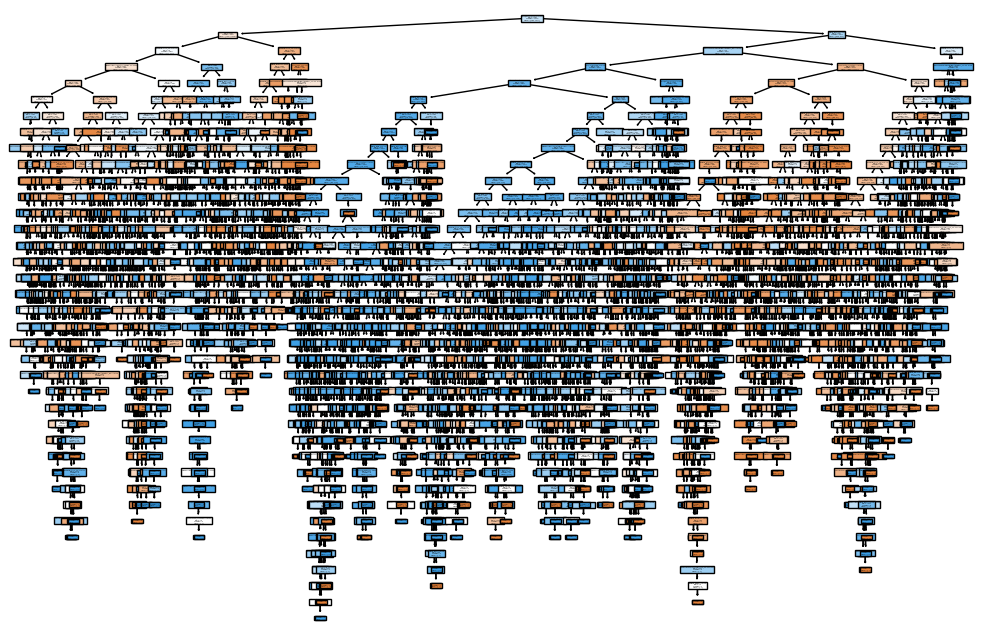

In [24]:
# Plot RF Model decision tree
tree = rf_model.estimators_[0]
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, filled=True)
plt.show

In [25]:
# Save model and scaler to file for flask api use
joblib.dump(rf_model, "../api/model.h5")
joblib.dump(X_scaler, "../api/scaler.bin")

['../api/scaler.bin']